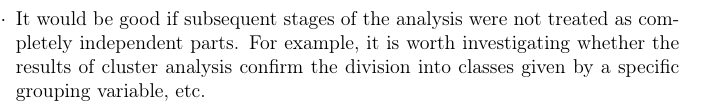

In [478]:
library(cluster)
library(caret)
library(dplyr)
library(clValid)
library(tidyverse)
library(factoextra)
library(e1071)

Warning message:
"pakiet 'e1071' został zbudowany w wersji R 4.2.3"


# Data

In [538]:
test <- read.csv('data/test_data.csv', stringsAsFactors = TRUE)
train <- read.csv('data/train_data.csv', stringsAsFactors = TRUE)

In [539]:
data = rbind(train, test)

In [540]:
numerical_columns <- names(data[sapply(data, is.numeric)])
numerical_columns <- numerical_columns[numerical_columns != "income_binary"]
factor_columns <- names(data[sapply(data, is.factor)])

In [541]:
data[numerical_columns] <- scale(data[numerical_columns])

In [542]:
cluster_data <- select(data, -income_binary)

In [543]:
#to do usunięcia będzie
#cluster_data <- cluster_data[0:3000, ]

In [544]:
dummy <- dummyVars("~ .", data = cluster_data, fullRank = TRUE)
cluster_data_onehot <- data.frame(predict(dummy, newdata = cluster_data))

# Internal validation

- kmeans
- pam
- agnes
- diana

In [547]:
methods <- c("kmeans", "pam", "agnes","diana")
k_range <- 2:8

internal_val <- clValid(cluster_data_onehot, nClust=k_range, clMethods=methods, validation="internal", method = "single", 
                        maxitems=nrow(cluster_data))

In [550]:
optimalScores(internal_val)

,Score,Method,Clusters
,<dbl>,<chr>,<chr>
Connectivity,0.0000000,kmeans,2
Dunn,1.0411833,kmeans,2
Silhouette,0.7600971,kmeans,2


In [551]:
k <- as.data.frame(internal_val@measures[,,"kmeans"])
k$method <- c('kmeans', 'kmeans', 'kmeans')

p <- as.data.frame(internal_val@measures[,,"pam"])
p$method <- c('PAM', "PAM", 'PAM')

a <- as.data.frame(internal_val@measures[,,"agnes"])
a$method <- c('AGNES', "AGNES", 'AGNES')

d <- as.data.frame(internal_val@measures[,,"diana"])
d$method <- c('DIANA', "DIANA", 'DIANA')

df <- rbind(k,p,a,d)

In [552]:
write.csv(df, 'assesment.csv', row.names = TRUE)

In [553]:
#df <- read.csv('assesment.csv', row.names = 1)

In [554]:
conn <- df[c(1, 4, 7, 10), ]
dunn <- df[c(2,5,8,11), ]
sil <- df[c(3,6,9,12), ]

In [555]:
conn_df <- conn %>%
  rownames_to_column(var = "Conn") %>%
  pivot_longer(cols = -c(Conn, method), 
               names_to = "k", 
               values_to = "Connectivity") %>%
  mutate(k = as.integer(k))  %>%
  select(-Conn)

dunn_df <- dunn %>%
  rownames_to_column(var = "Du") %>%
  pivot_longer(cols = -c(Du, method), 
               names_to = "k", 
               values_to = "Dunn") %>%
  mutate(k = as.integer(k))  %>%
  select(-Du)

sil_df <- sil %>%
  rownames_to_column(var = "Silh") %>%
  pivot_longer(cols = -c(Silh, method), 
               names_to = "k", 
               values_to = "Silhouette") %>%
  mutate(k = as.integer(k))  %>%
  select(-Silh)

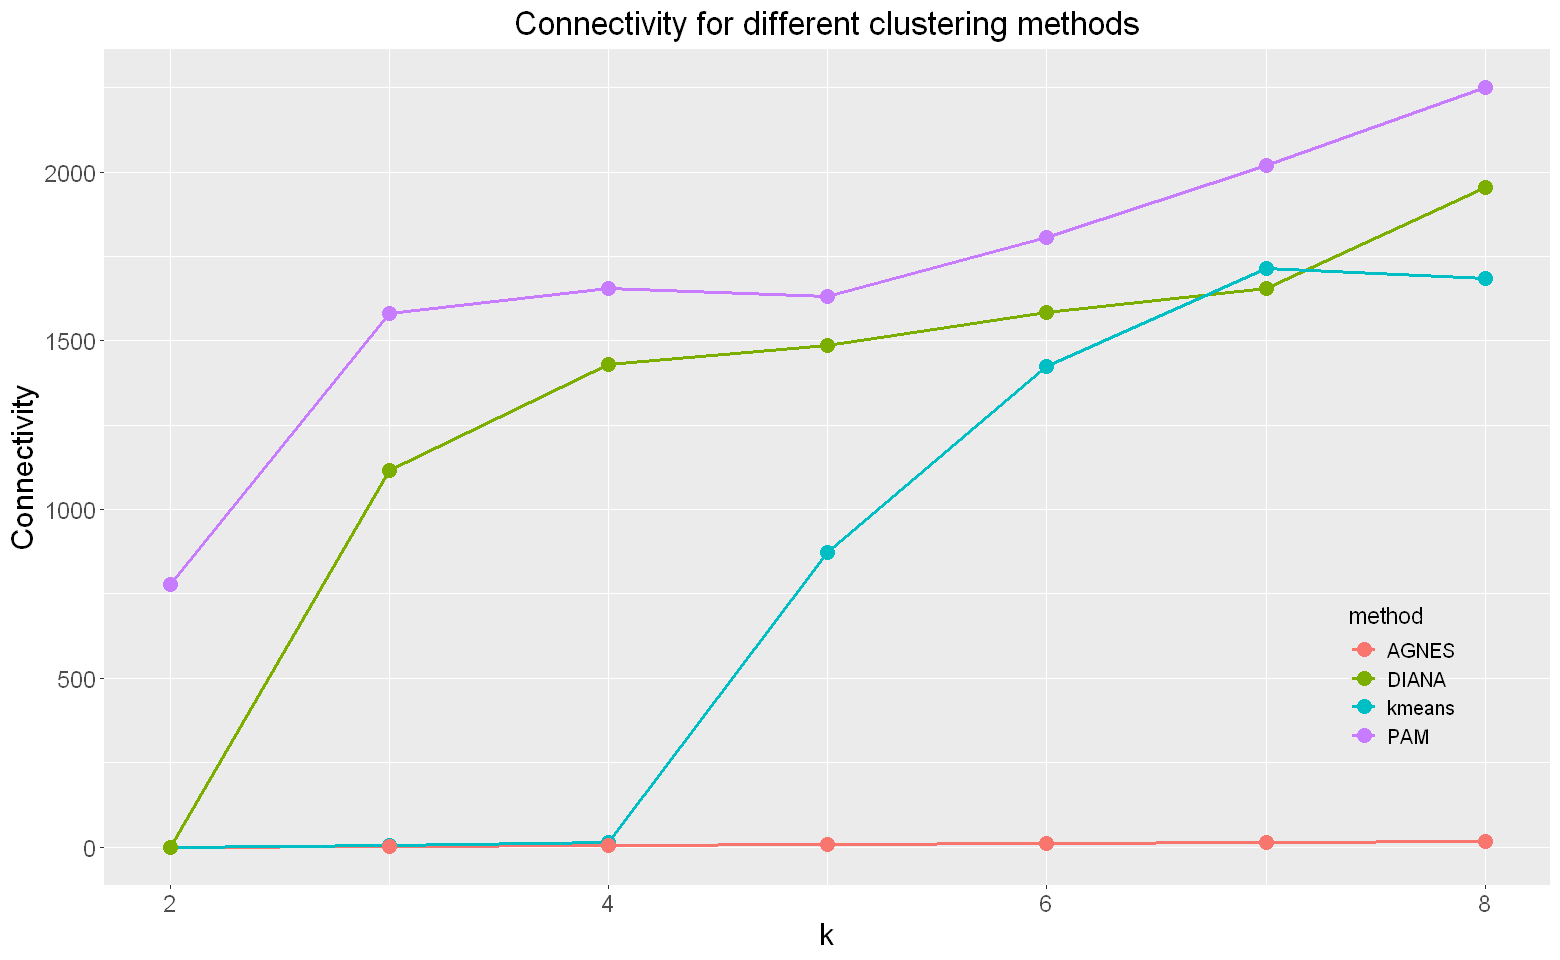

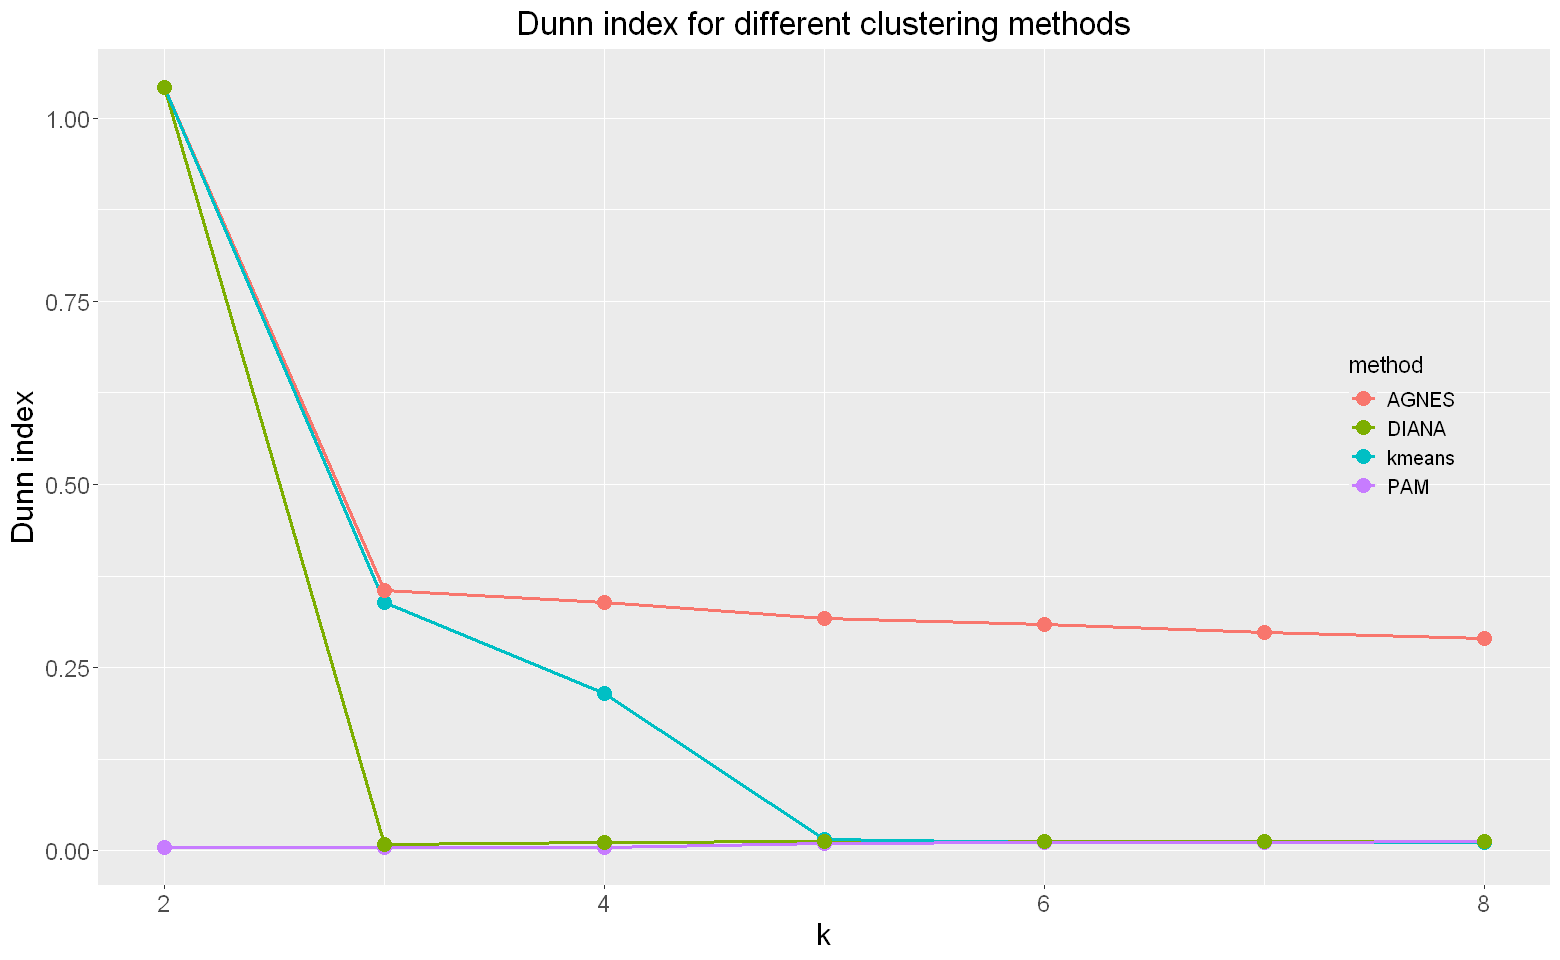

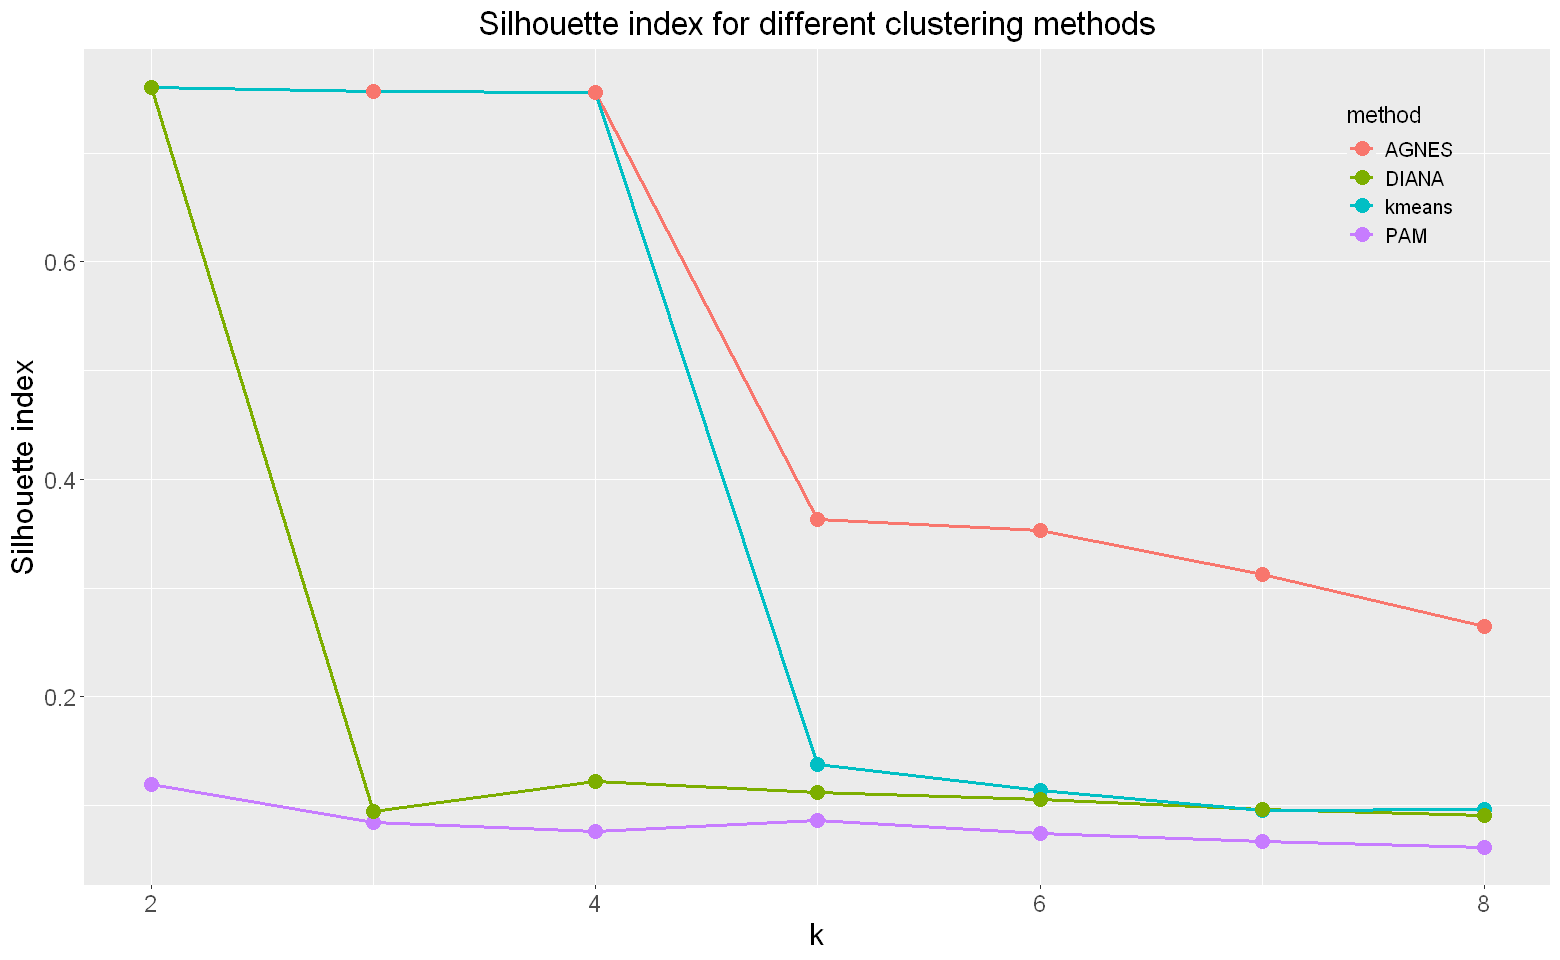

In [556]:
options(repr.plot.width = 13, repr.plot.height = 8)
#Connectivity
conn_plot <- ggplot() +
  geom_line(data=conn_df, aes(x=k, y=Connectivity, color=method), size=1, linetype = "solid") +
  geom_point(data=conn_df, aes(x=k, y=Connectivity, color=method), size=4) +
  labs(title='Connectivity for different clustering methods',
       y='Connectivity',
       x='k') +
  theme(axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14),
        axis.title = element_text(size=18),
        plot.title = element_text(hjust = 0.5, size=20),
        legend.position = c(0.90, 0.25),
        legend.text = element_text(size = 12), 
        legend.title = element_text(size = 14)) + 
  theme(legend.background = element_rect(fill = alpha('white', 0)))

#Dunn index
dunn_plot <- ggplot() +
  geom_line(data=dunn_df, aes(x=k, y=Dunn, color=method), size=1, linetype = "solid") +
  geom_point(data=dunn_df, aes(x=k, y=Dunn, color=method), size=4) +
  labs(title='Dunn index for different clustering methods',
       y='Dunn index',
       x='k') +
  theme(axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14),
        axis.title = element_text(size=18),
        plot.title = element_text(hjust = 0.5, size=20),
        legend.position = c(0.90, 0.55),
        legend.text = element_text(size = 12), 
        legend.title = element_text(size = 14)) + 
  theme(legend.background = element_rect(fill = alpha('white', 0)))

#Silhouette
sil_plot <- ggplot() +
  geom_line(data=sil_df, aes(x=k, y=Silhouette, color=method), size=1, linetype = "solid") +
  geom_point(data=sil_df, aes(x=k, y=Silhouette, color=method), size=4) +
  labs(title='Silhouette index for different clustering methods',
       y='Silhouette index',
       x='k') +
  theme(axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14),
        axis.title = element_text(size=18),
        plot.title = element_text(hjust = 0.5, size=20),
        legend.position = c(0.90, 0.85),
        legend.text = element_text(size = 12), 
        legend.title = element_text(size = 14)) + 
  theme(legend.background = element_rect(fill = alpha('white', 0)))


conn_plot
dunn_plot
sil_plot

ggsave("images/conn_plot.jpg", conn_plot, width = 13, height = 8, units = "in", dpi = 300)
ggsave("images/dunn_plot.jpg", conn_plot, width = 13, height = 8, units = "in", dpi = 300)
ggsave("images/sil_plot.jpg", conn_plot, width = 13, height = 8, units = "in", dpi = 300)

# Silhouette

In [557]:
#one hot + euclidean
diss_matrix <- as.matrix(dist(cluster_data_onehot, method = "euclidean"))

In [558]:
write.csv(diss_matrix, 'diss_matrix.csv', row.names = TRUE)

In [559]:
#diss_matrix <- as.matrix(read.csv('diss_matrix.csv', row.names=1))

In [560]:
options(repr.plot.width = 12, repr.plot.height = 8)

  cluster size ave.sil.width
1       1 1832          0.10
2       2 1168          0.18


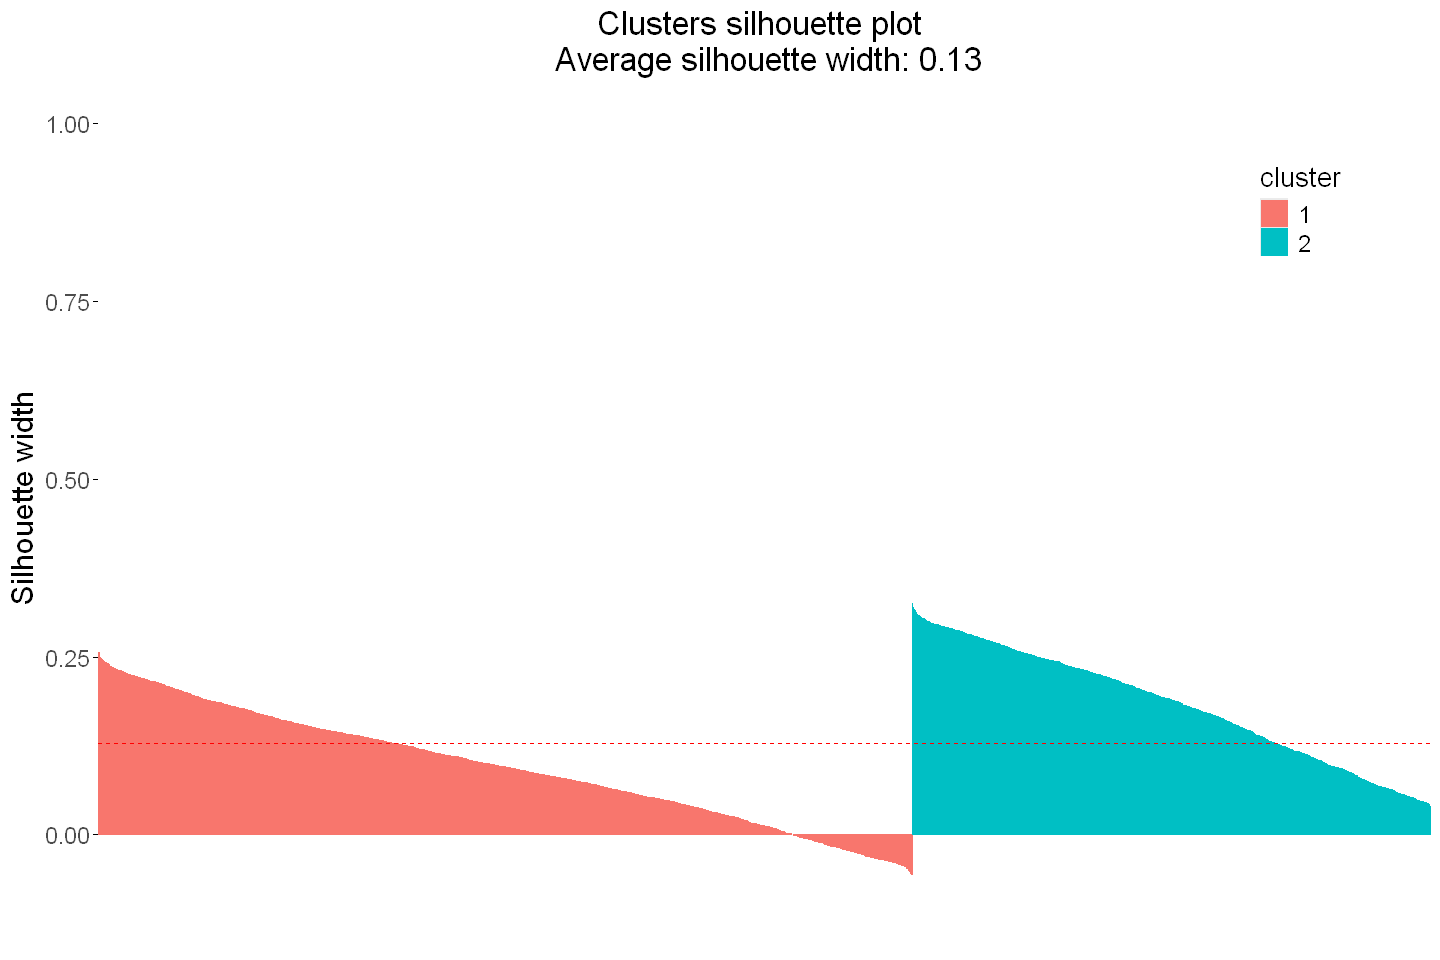

In [561]:
kmeans <- kmeans(cluster_data_onehot, 2, nstart=10)$cluster
sil_kmeans <- silhouette(kmeans, dmatrix=diss_matrix)
kmeans_silh_plot <- fviz_silhouette(sil_kmeans, ylab='Silhouette width', print_summary=FALSE) +
                        theme(axis.text = element_text(size = 14),
                             axis.title = element_text(size = 18),
                             plot.title = element_text(size =20, hjust=0.5), 
                             legend.position = c(0.90, 0.85),
                             legend.text = element_text(size = 14), 
                             legend.title = element_text(size = 16)) +
                        theme(legend.background = element_rect(fill = alpha('white', 0)))

kmeans_silh_plot

ggsave("images/kmeans_silh_plot.jpg", kmeans_silh_plot, width = 12, height = 8, units = "in", dpi = 300)

  cluster size ave.sil.width
1       1 1937          0.10
2       2 1063          0.16


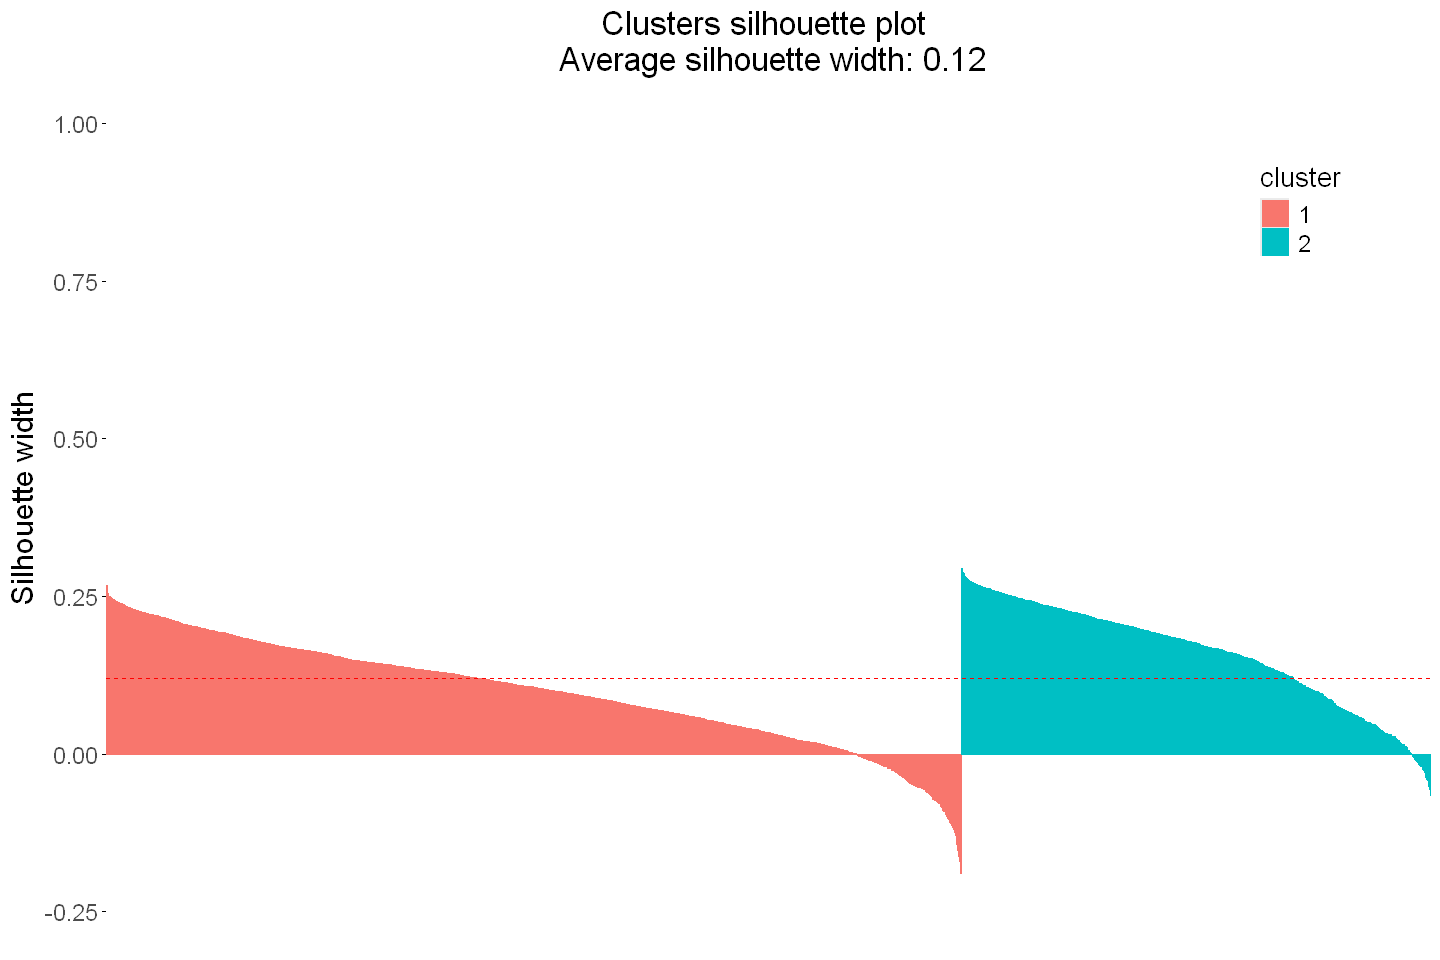

In [562]:
pam <- pam(x = diss_matrix, diss=TRUE, k=2)
sil_pam <- silhouette(pam$clustering, dmatrix=diss_matrix)
pam_silh_plot <- fviz_silhouette(sil_pam, ylab='Silhouette width', print_summary=FALSE) +
                        theme(axis.text = element_text(size = 14),
                             axis.title = element_text(size = 18),
                             plot.title = element_text(size =20, hjust=0.5), 
                             legend.position = c(0.90, 0.85),
                             legend.text = element_text(size = 14), 
                             legend.title = element_text(size = 16)) +
                        theme(legend.background = element_rect(fill = alpha('white', 0)))

pam_silh_plot

ggsave("images/pam_silh_plot.jpg", pam_silh_plot, width = 12, height = 8, units = "in", dpi = 300)

  cluster size ave.sil.width
1       1 2985          0.76
2       2   15          0.79


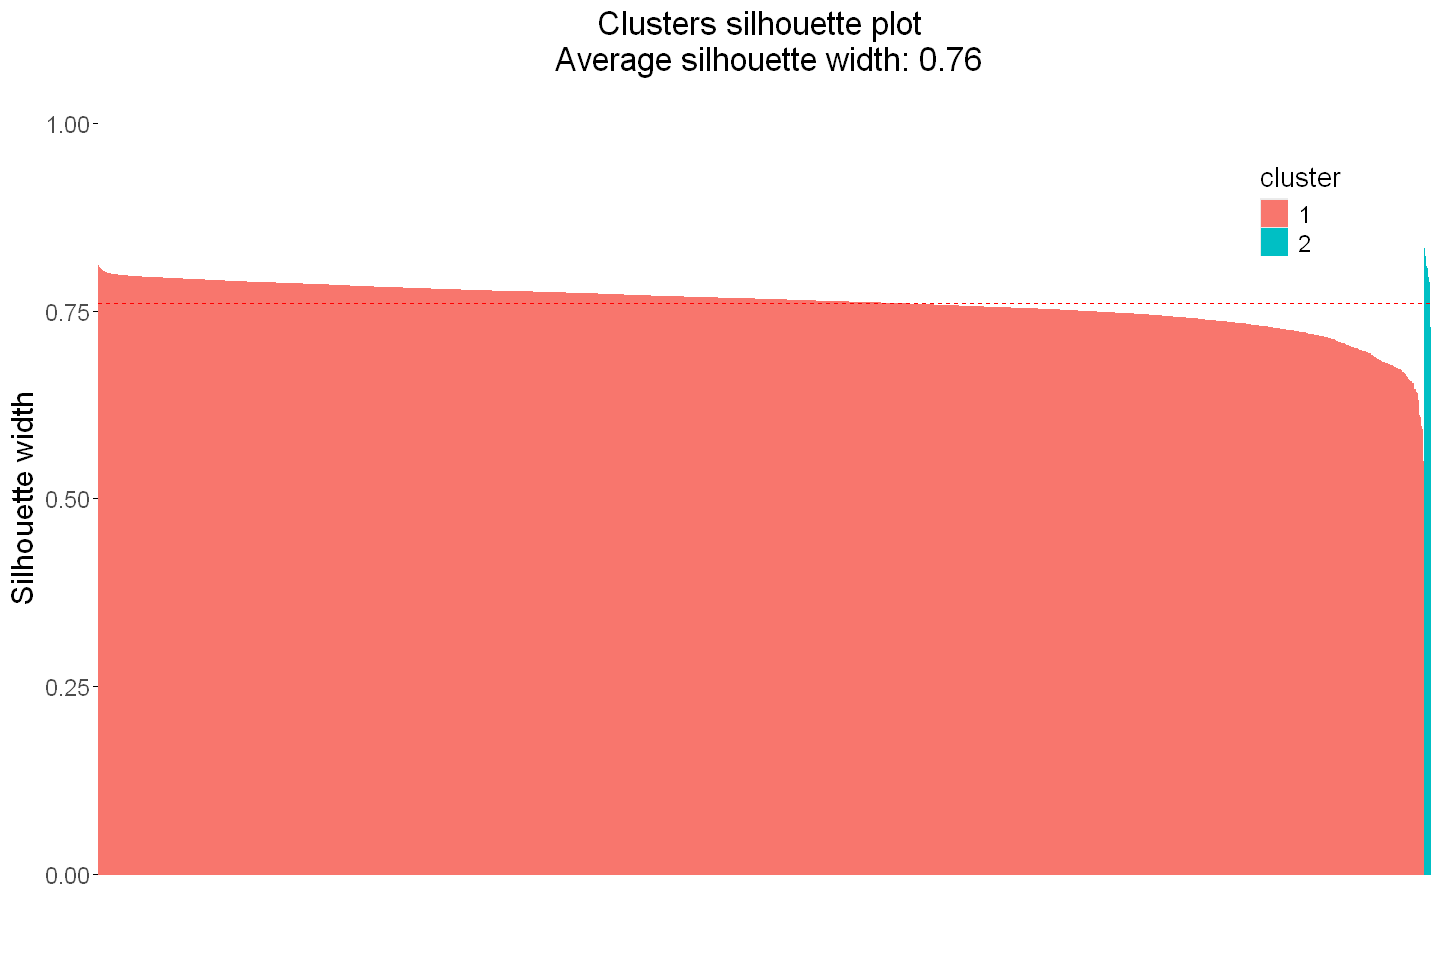

In [563]:
agnes <- cutree(agnes(diss_matrix, method = 'single', diss = TRUE), k=2)
sil_agnes <- silhouette(agnes, dmatrix=diss_matrix)
agnes_silh_plot <- fviz_silhouette(sil_agnes, ylab='Silhouette width', print_summary=FALSE) +
                        theme(axis.text = element_text(size = 14),
                             axis.title = element_text(size = 18),
                             plot.title = element_text(size =20, hjust=0.5), 
                             legend.position = c(0.90, 0.85),
                             legend.text = element_text(size = 14), 
                             legend.title = element_text(size = 16)) +
                        theme(legend.background = element_rect(fill = alpha('white', 0)))

agnes_silh_plot

ggsave("images/agnes_silh_plot.jpg", agnes_silh_plot, width = 12, height = 8, units = "in", dpi = 300)

  cluster size ave.sil.width
1       1 2985          0.76
2       2   15          0.79


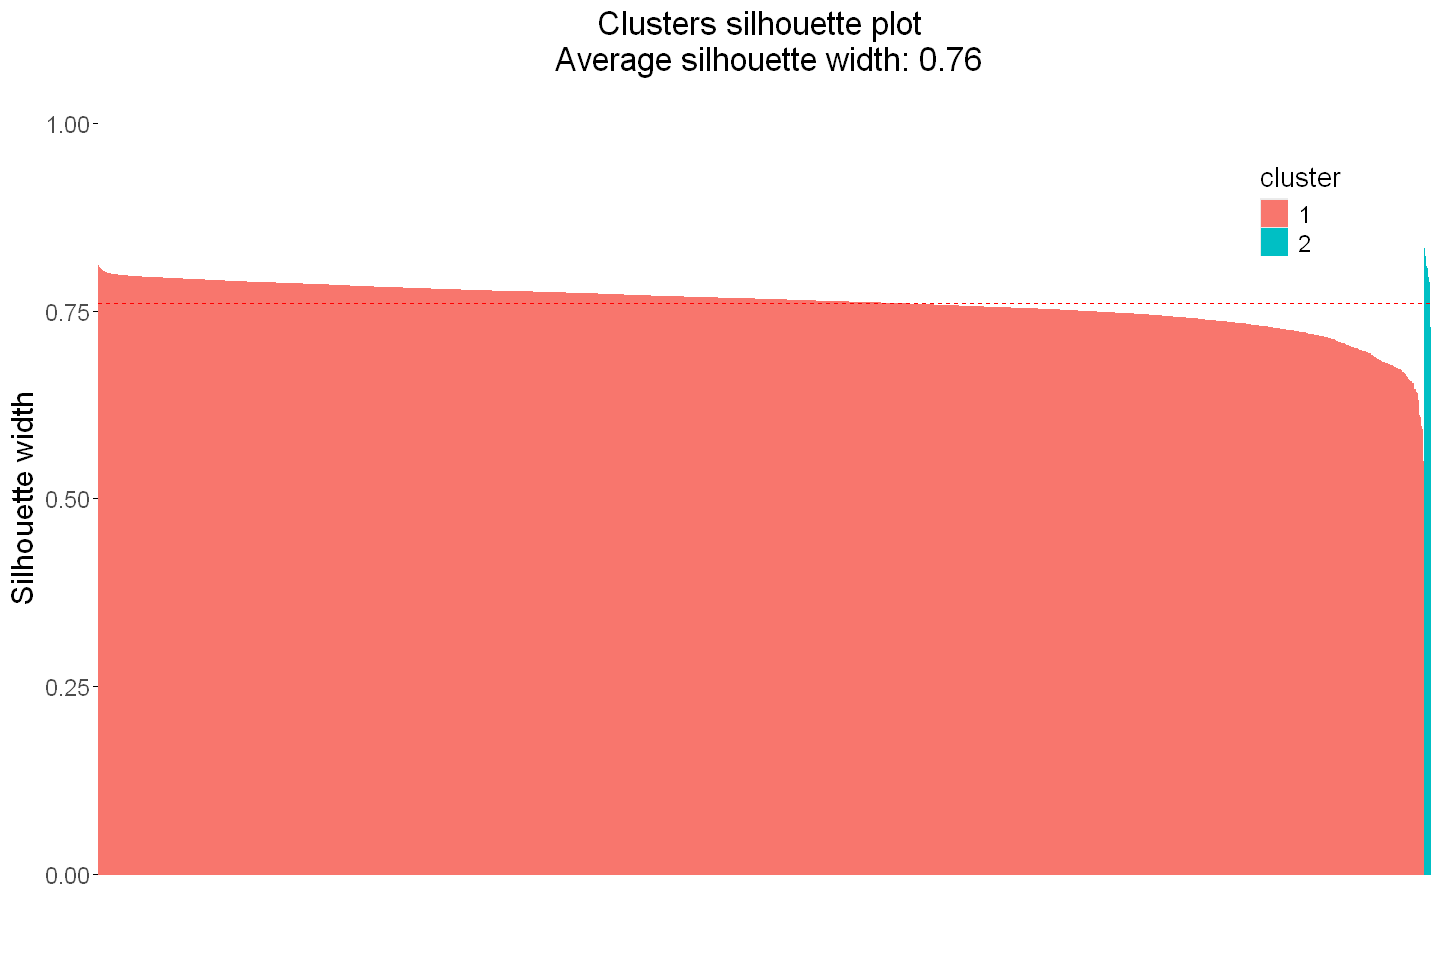

In [564]:
diana <- cutree(diana(diss_matrix, diss=TRUE), k=2)
sil_diana <- silhouette(diana, dmatrix=diss_matrix)
diana_silh_plot <- fviz_silhouette(sil_diana, ylab='Silhouette width', print_summary=FALSE) +
                        theme(axis.text = element_text(size = 14),
                             axis.title = element_text(size = 18),
                             plot.title = element_text(size =20, hjust=0.5), 
                             legend.position = c(0.90, 0.85),
                             legend.text = element_text(size = 14), 
                             legend.title = element_text(size = 16)) +
                        theme(legend.background = element_rect(fill = alpha('white', 0)))

diana_silh_plot

ggsave("images/diana_silh_plot.jpg", diana_silh_plot, width = 12, height = 8, units = "in", dpi = 300)

# Not done Gower

In [179]:
#COMPUTATIONS TOO LONG
diss_matrix_gow <- daisy(cluster_data, metric = "gower")

agnes_silh_gow <- c()
pam_silh_gow <- c()
diana_silh_gow <- c()

#for gower
for (k in 2:8){
    
    #for gower, can't use kmeans because categorical variables occurs
    
    pam.res <- pam(diss_matrix_gow, diss = TRUE, k = 3)
    sil.pam <- silhouette(pam.res$clustering, diss_matrix_gow)
    pam_silh_gow <- c(pam_silh_gow, mean(sil.pam[, 3]))
    
    agnes.res <- agnes(diss_matrix_gow, method = "single", diss = TRUE)
    agnes.partition <- cutree(agnes.res, k = 4)
    sil.agnes <- silhouette(agnes.partition, diss_matrix_gow)
    agnes_silh_gow <- c(agnes_silh_gow, mean(sil.agnes[, 3]))
    
    diana.res <- diana(x=diss_matrix_gow, diss=TRUE)
    diana.partition <- cutree(diana.res, k=4)
    sil.diana <- silhouette(diana.partition, diss_matrix_gow)
    diana_silh_gow <- c(diana_silh_gow, mean(sil.diana[,3]))
}